Mounted at /content/drive

Threshold (Mean |Kendall's Tau|): 0.1216

Fitur yang dipilih berdasarkan threshold: ['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Income']

MEMULAI PELATIHAN MODEL DNN KCC + SELF-ATTENTION...
Epoch 1/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8411 - loss: 0.4195 - val_accuracy: 0.8479 - val_loss: 0.4000
Epoch 2/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8481 - loss: 0.3984 - val_accuracy: 0.8486 - val_loss: 0.3990
Epoch 3/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8482 - loss: 0.3975 - val_accuracy: 0.8490 - val_loss: 0.3992
Epoch 4/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8487 - loss: 0.3969 - val_accuracy: 0.8489 - val_loss: 0.3996
Epoch 5/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8491 - loss: 0.3965 - val_accuracy: 0.8488 - val_loss: 0.3996
Epoch 6/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


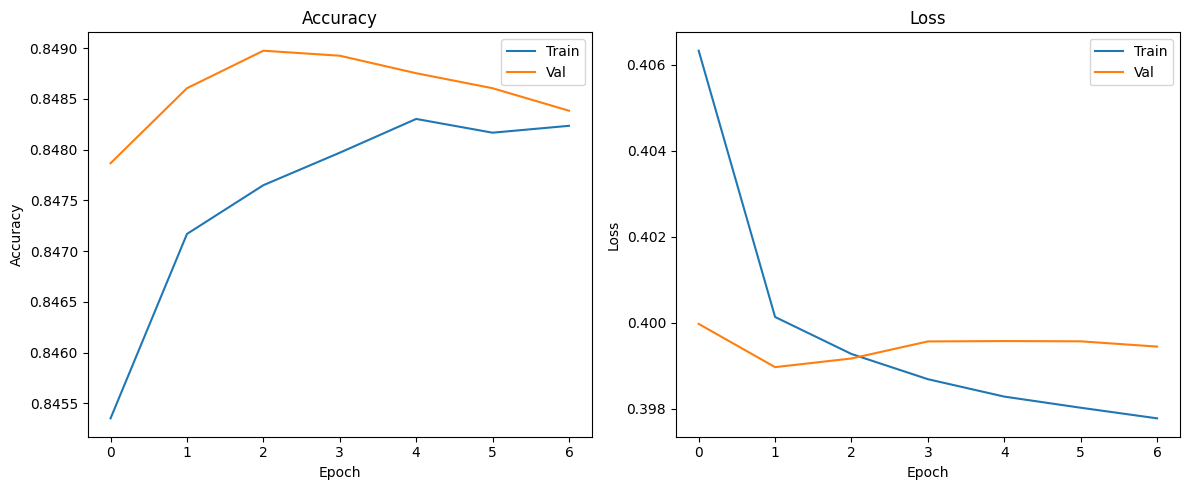

/tmp/ipython-input-1-3777754728.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Kendall_Tau', y='Feature', data=kendall_df_sorted, palette='coolwarm')


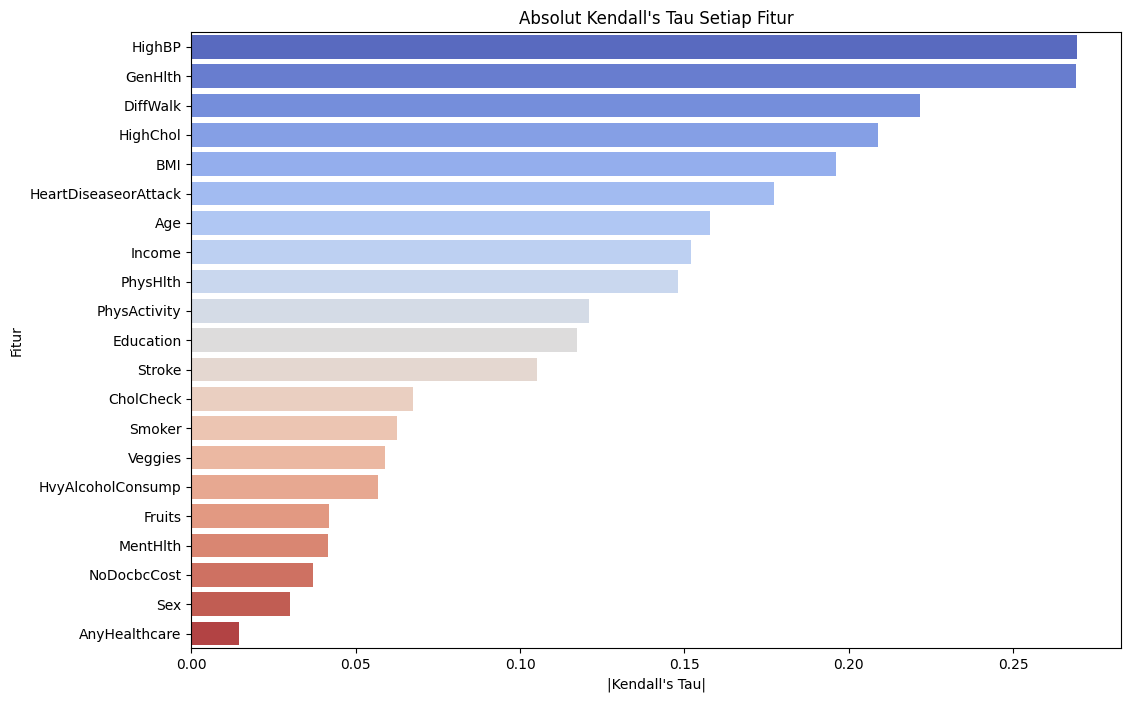

In [1]:
# ========================
# IMPORT LIBRARY & SET SEED
# ========================
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import kendalltau
from scipy.stats.mstats import winsorize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Lambda

# Set Seed
SEED = 44
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ========================
# LOAD & PREPROCESS DATA
# ========================
from google.colab import drive
drive.mount('/content/drive')

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset/diabetes_012_health_indicators_BRFSS2015.csv')
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

# Preprocessing
X['BMI'] = winsorize(X['BMI'], limits=[0.005, 0.005])
X['MentHlth'] = np.where(X['MentHlth'] > 30, 30, X['MentHlth'])
X['PhysHlth'] = np.where(X['PhysHlth'] > 30, 30, X['PhysHlth'])

robust_features = ['BMI', 'MentHlth', 'PhysHlth']
minmax_features = ['Age', 'Education', 'Income', 'GenHlth']

scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

X[robust_features] = scaler_robust.fit_transform(X[robust_features])
X[minmax_features] = scaler_minmax.fit_transform(X[minmax_features])

# ========================
# ONE-HOT ENCODING TARGET
# ========================
y_encoded = to_categorical(y)

# ================================
# KENDALL'S CORRELATION (KCC)
# ================================
kendall_results = []
for feature in X.columns:
    tau, p = kendalltau(X[feature], y)
    kendall_results.append({
        'Feature': feature,
        'Kendall_Tau': tau,
        'Abs_Kendall_Tau': abs(tau),
        'P_Value': p
    })

kendall_df = pd.DataFrame(kendall_results)
kendall_df_sorted = kendall_df.sort_values(by='Abs_Kendall_Tau', ascending=False)

# Tentukan threshold sebagai rata-rata |tau|
mean_abs_tau = kendall_df['Abs_Kendall_Tau'].mean()
print(f"\nThreshold (Mean |Kendall's Tau|): {mean_abs_tau:.4f}")

# Pilih fitur dengan |tau| >= threshold
top_features = kendall_df[kendall_df['Abs_Kendall_Tau'] >= mean_abs_tau]['Feature'].tolist()
print(f"\nFitur yang dipilih berdasarkan threshold: {top_features}")

# ==========================================
# SPLIT DATA DENGAN FITUR TERPILIH
# ==========================================
X_top = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_top, y_encoded, test_size=0.2, random_state=SEED, stratify=y
)
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train.argmax(axis=1)
)

# ==========================================
# BUILD DNN + SELF-ATTENTION MODEL
# ==========================================
input_layer = Input(shape=(X_top.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# Expand untuk self-attention
x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

# Self-Attention
attn_output = MultiHeadAttention(num_heads=4, key_dim=4)(x_expanded, x_expanded)
attn_output = LayerNormalization()(attn_output + x_expanded)

# Squeeze back to 2D
attn_output_squeezed = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_output)

# Output Layer
output_layer = Dense(3, activation='softmax')(attn_output_squeezed)

# Final Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==========================================
# TRAIN MODEL
# ==========================================
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

print("\nMEMULAI PELATIHAN MODEL DNN KCC + SELF-ATTENTION...")
history = model.fit(
    X_train_main, y_train_main,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=50,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# EVALUASI MODEL
# ==========================================
y_pred_prob = model.predict(X_test, verbose=0)
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test, axis=1)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true_class, y_pred_class, digits=4))

roc_auc = roc_auc_score(y_test, y_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC (Macro Average): {roc_auc:.4f}")

# ==========================================
# VISUALISASI
# ==========================================
# Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Barplot tau
plt.figure(figsize=(12, 8))
sns.barplot(x='Abs_Kendall_Tau', y='Feature', data=kendall_df_sorted, palette='coolwarm')
plt.title("Absolut Kendall's Tau Setiap Fitur")
plt.xlabel('|Kendall\'s Tau|')
plt.ylabel('Fitur')
plt.show()
